<img src="test.JPG" alt="Drawing" style="width: 400px;"/>

In [2]:
import pandas as pd
import numpy as np
import random
import xgboost as xgb
from xgboost import plot_importance 
from toad.metrics import KS,AUC
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imbalanced_ensemble.ensemble import SelfPacedEnsembleClassifier
from sklearn.metrics import roc_curve

In [3]:
def calAUC(y_pred,y_true):
    y_true = list(y_true)
    f = list(zip(y_pred,y_true))
    rank = [values2 for values1,values2 in sorted(f,key=lambda x:x[0])]
    rankList = [i+1 for i in range(len(rank)) if rank[i]==1]
    posNum = 0
    negNum = 0
    for i in range(len(y_true)):
        if(y_true[i]==1):
            posNum+=1
        else:
            negNum+=1
    auc = 0
    auc = (sum(rankList)- (posNum*(posNum+1))/2)/(posNum*negNum)
    print(auc)
    return auc

In [4]:
data=pd.read_csv("credit.csv")
x = data.drop(['default'],axis=1)
y = data.default
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [13]:
x 

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,90000,2,2,2,34,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
2,50000,2,2,1,37,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
3,50000,1,2,1,57,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
4,50000,1,1,2,37,0,0,0,0,0,...,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,80000,1,2,2,34,2,2,2,2,2,...,79384.0,77519.0,82607.0,81158.0,7000.0,3500.0,0.0,7000.0,0.0,4000.0
23996,150000,1,3,2,43,-1,-1,-1,-1,0,...,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0
23997,30000,1,2,2,37,4,3,2,-1,0,...,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0
23998,80000,1,3,1,41,1,-1,0,0,0,...,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0


In [5]:
params = {'n_estimators':1000,
         'max_depth':4,
         'subsample':0.7,
         'learning_rate':0.05}

In [6]:
model = xgb.XGBClassifier(n_estimators = 1000,max_depth=4,verbosity=1,subsample = 0.7,learning_rate=0.05,random_state=42)

[0]	validation_0-auc:0.74694	validation_1-auc:0.74442
[200]	validation_0-auc:0.83488	validation_1-auc:0.78254
[320]	validation_0-auc:0.85773	validation_1-auc:0.77855
AUC: 0.783144 
KS: 0.435181 


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

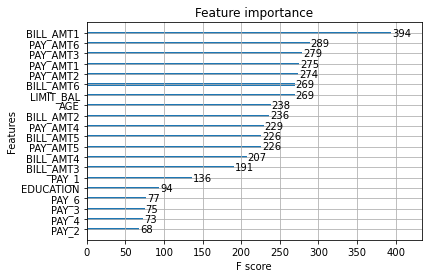

In [7]:
model.fit(x_train,y_train,eval_metric=['auc'],verbose=200,eval_set = [( x_train,y_train),(x_test,y_test)],early_stopping_rounds=200)
pred = model.predict_proba(x_test)
print('AUC: {:.6f} '.format(AUC(pred[:,1],y_test)))
print('KS: {:.6f} '.format(KS(pred[:,1],y_test)))
plot_importance(model,max_num_features=20)

In [8]:
clf = SelfPacedEnsembleClassifier(
        base_estimator = model,
        verbose=True,
        k_bins=5,
    #基准分类模型 可以自定义，需要模型包含fit等方法
        n_estimators = 40,
        random_state=49,
    ).fit(x_train, y_train,
          balancing_schedule='progressive',
          eval_datasets  = {'valid': (x_test, y_test)},
          train_verbose= {
            'granularity': 1,
            'print_distribution': True,
            'print_metrics': True}
         )

[10:14:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             ┃                     ┃            Data: train             ┃            Data: valid             ┃
┃ #Estimators ┃ Class Distribution  ┃               Metric               ┃               Metric               ┃
┃             ┃                     ┃  acc    balanced_acc   weighted_f1 ┃  acc    balanced_acc   weighted_f1 ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃      1      ┃ {0: 14052, 1: 3948} ┃ 0.869      0.738          0.856    ┃ 0.818      0.660          0.797    ┃
[10:14:58] WARNING

┃     19      ┃ {0: 9389, 1: 3948}  ┃ 0.872      0.742          0.859    ┃ 0.817      0.657          0.795    ┃
[10:16:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
┃     20      ┃ {0: 9130, 1: 3948}  ┃ 0.872      0.743          0.860    ┃ 0.817      0.658          0.796    ┃
[10:16:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
┃     21      ┃ {0: 8871, 1: 3948}  ┃ 0.873      0.744          0.861    ┃ 0.817      0.657          0.795    ┃
[10:16:19] WARNING: C:/Users/Administrator/w

┃     39      ┃ {0: 4208, 1: 3948}  ┃ 0.884      0.770          0.875    ┃ 0.815      0.663          0.796    ┃
[10:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
┃     40      ┃ {0: 3948, 1: 3948}  ┃ 0.885      0.772          0.876    ┃ 0.815      0.663          0.796    ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃    final    ┃ {0: 3948, 1: 3948}  ┃ 0.885      0.772          0.876    ┃ 0.815      0.663          0.796    ┃
┗━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [9]:
pred =clf.predict_proba(x_test)
print('AUC: {:.6f} '.format(AUC(pred[:,1],y_test)))
print('KS: {:.6f} '.format(KS(pred[:,1],y_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AUC: 0.764954 
KS: 0.402650 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [12]:
gg

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,170000.0,2.0,1.0,2.0,36.0,-1.0,-1.0,2.0,-1.0,-1.0,...,416.0,2304.0,323.0,-1092.0,1416.0,0.0,2304.0,0.0,0.0,0.0
1,50000.0,1.0,3.0,1.0,60.0,1.0,2.0,0.0,0.0,0.0,...,50284.0,50740.0,30175.0,30407.0,0.0,2310.0,1766.0,1201.0,1232.0,1199.0
2,50000.0,2.0,2.0,2.0,43.0,1.0,2.0,0.0,0.0,0.0,...,48010.0,24331.0,25553.0,26733.0,0.0,2000.0,1000.0,2000.0,2000.0,2000.0
3,20000.0,1.0,1.0,2.0,23.0,0.0,0.0,0.0,0.0,0.0,...,7853.0,8565.0,9565.0,12065.0,1276.0,1288.0,1000.0,1000.0,2500.0,1000.0
4,150000.0,2.0,1.0,2.0,24.0,0.0,0.0,0.0,0.0,0.0,...,16452.0,17281.0,18576.0,18783.0,4000.0,2000.0,2000.0,2000.0,2000.0,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17979,20000.0,2.0,2.0,1.0,43.0,0.0,0.0,0.0,0.0,0.0,...,16432.0,16174.0,16499.0,12882.0,1558.0,1286.0,1204.0,529.0,467.0,544.0
17980,70000.0,2.0,2.0,2.0,26.0,2.0,0.0,0.0,0.0,0.0,...,69007.0,61845.0,60184.0,66801.0,3120.0,3303.0,2800.0,2200.0,7600.0,0.0
17981,250000.0,2.0,2.0,1.0,29.0,-1.0,-1.0,-1.0,0.0,0.0,...,49140.0,32699.0,32949.0,34150.0,0.0,49140.0,1596.0,5000.0,2000.0,1800.0
17982,200000.0,1.0,2.0,1.0,37.0,-2.0,-1.0,-1.0,-1.0,0.0,...,1946.0,11900.0,6344.0,4747.0,598.0,1950.0,11921.0,4.0,3.0,1201.0


In [10]:
gg=pd.read_csv('sampled_data.csv')
gg.columns = data.columns
Y_train = gg.pop('default')
X_train = gg

[0]	validation_0-auc:0.74708	validation_1-auc:0.74423
[200]	validation_0-auc:0.83513	validation_1-auc:0.78108
[346]	validation_0-auc:0.86043	validation_1-auc:0.77747
AUC: 0.783518 
KS: 0.435451 


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

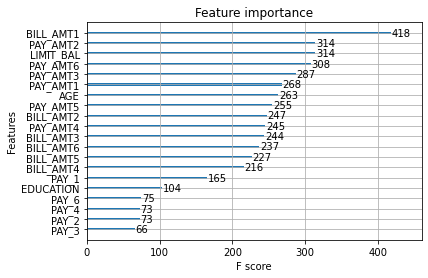

In [11]:
model.fit(X_train,Y_train,eval_metric=['auc'],verbose=200,eval_set = [( X_train,Y_train),(x_test,y_test)],early_stopping_rounds=200)
pred = model.predict_proba(x_test)
print('AUC: {:.6f} '.format(AUC(pred[:,1],y_test)))
print('KS: {:.6f} '.format(KS(pred[:,1],y_test)))
plot_importance(model,max_num_features=20)

In [14]:
ensembles = {}
ensembles['spe'] = clf

Visualizer evaluating model spe on dataset train :: 100%|██████████████████████████████| 40/40 [00:04<00:00,  9.00it/s]
Visualizer evaluating model spe on dataset valid :: 100%|██████████████████████████████| 40/40 [00:01<00:00, 23.30it/s]


Visualizer computing confusion matrices.. Finished!


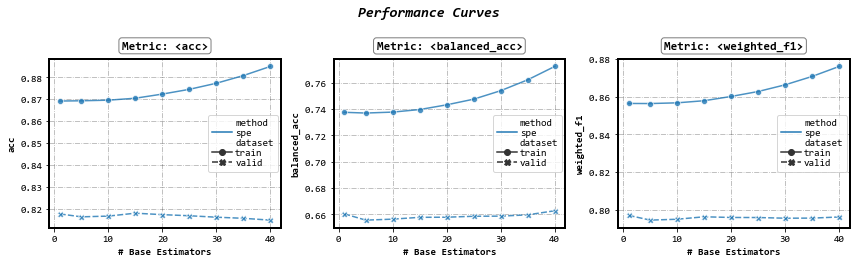

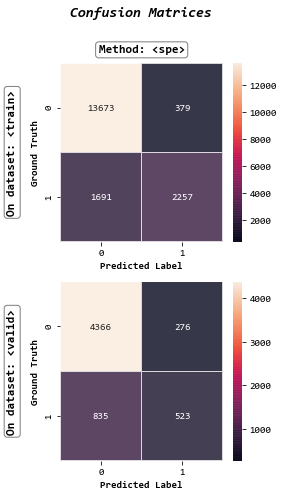

In [15]:
from imbalanced_ensemble.visualizer import ImbalancedEnsembleVisualizer

visualizer = ImbalancedEnsembleVisualizer(
        eval_datasets = None,
        eval_metrics = None,
    ).fit(
        ensembles = ensembles,
        granularity = 5,
    )
fig, axes = visualizer.performance_lineplot(
        on_ensembles=None,
        on_datasets=None,
        split_by=[],
        n_samples_as_x_axis=False,
        sub_figsize=(4, 3.3),
        sup_title=True,
        alpha=0.8,
    )
fig, axes = visualizer.confusion_matrix_heatmap(
        on_ensembles=None,
        on_datasets=None,
        sub_figsize=(4, 3.3),
    )
